In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
from statkit.decision import NetBenefitDisplay

# 解决中文问题
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 1.读取数据
tData_train = pd.read_csv("data/ttest_data.csv", encoding='utf-8-sig')
select_features = []
with open("./data/五折/features.txt", "r") as f:
       for feature in f.readlines():
              select_features.append(str(feature).strip())
# print(select_features)
X = tData_train[select_features]
y = tData_train['label']

# 2. 分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 3. 标准化
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [2]:

# 4. 初始化模型
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=0),
    "SVM": SVC(probability=True, random_state=0),
    "KNN": KNeighborsClassifier()
}
# 存储评估指标
metrics = {}

# 训练模型并计算评估指标
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 计算评估指标
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, labels=(0, 1), target_names=("良性", "恶性"))
    
    # 保存指标
    metrics[name] = {
        "accuracy score": acc,
        "precision score": precision,
        "recall score": recall,
        "F1 score": f1,
        "confusion matrix": conf_matrix,
        "classification report": report
    }

# 输出评估指标
for name, metric in metrics.items():
    print(f"{name} 的评估指标:")
    print(f"accuracy score: {metric['accuracy score']:.2f}")
    print(f"precision score: {metric['precision score']:.2f}")
    print(f"recall score: {metric['recall score']:.2f}")
    print(f"F1 score: {metric['F1 score']:.2f}")
    print(f"confusion matrix:\n{metric['confusion matrix']}\n")
    print(f"classification report:\n{metric['classification report']}\n")

Logistic Regression 的评估指标:
accuracy score: 0.92
precision score: 0.72
recall score: 0.53
F1 score: 0.61
confusion matrix:
[[1789   47]
 [ 109  121]]

classification report:
              precision    recall  f1-score   support

          良性       0.94      0.97      0.96      1836
          恶性       0.72      0.53      0.61       230

    accuracy                           0.92      2066
   macro avg       0.83      0.75      0.78      2066
weighted avg       0.92      0.92      0.92      2066


Random Forest 的评估指标:
accuracy score: 0.93
precision score: 0.80
recall score: 0.47
F1 score: 0.59
confusion matrix:
[[1808   28]
 [ 121  109]]

classification report:
              precision    recall  f1-score   support

          良性       0.94      0.98      0.96      1836
          恶性       0.80      0.47      0.59       230

    accuracy                           0.93      2066
   macro avg       0.87      0.73      0.78      2066
weighted avg       0.92      0.93      0.92      2066


SVM 

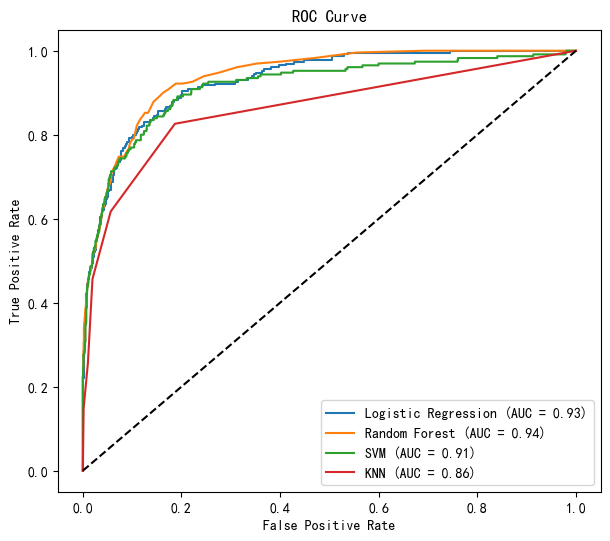

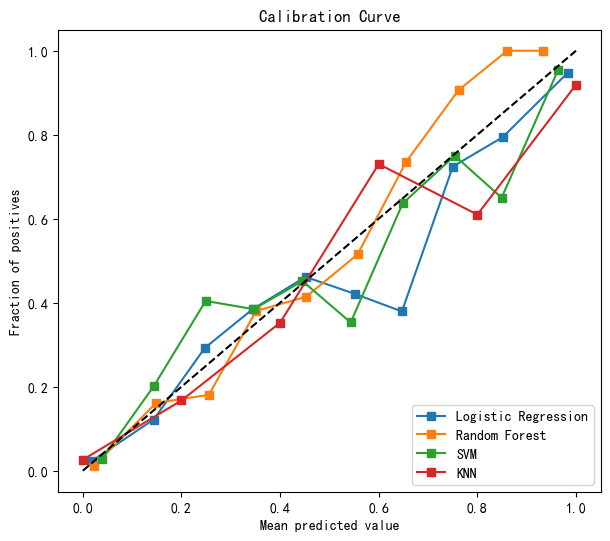

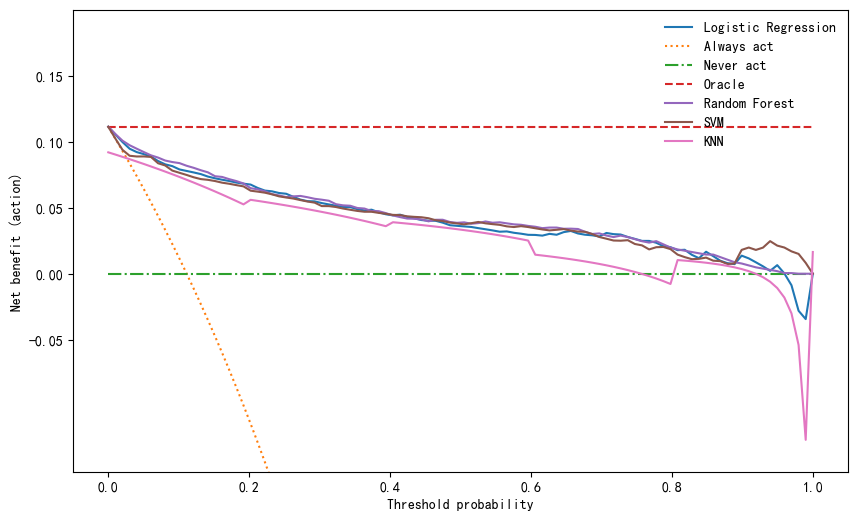

In [25]:


# 5. 绘制ROC曲线
plt.figure(figsize=(7, 6))

# ROC曲线

for name, model in models.items():
    # model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 6. 绘制校准曲线

plt.figure(figsize=(7, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()

# 7. 绘制决策曲线
plt.figure(figsize=(10, 6))

# 收集每个模型的预测概率
n = 0
for name, model in models.items():
    y_pred_base = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
    if n == 0:  # 第一个模型绘制参考线
        NetBenefitDisplay.from_predictions(y_test, y_pred_base, name=name, ax=plt.gca(), show_references=True)
    else:   # 其他模型绘制不绘制参考线及标签
        NetBenefitDisplay.from_predictions(y_test, y_pred_base, name=name, ax=plt.gca(), show_references=False)
    n += 1
y_ticks = np.arange(-0.05, 0.2, 0.05)
plt.yticks(y_ticks)
plt.ylim(-0.15, 0.2)
# plt.legend(loc='lower right')
plt.show()

